# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [2]:
# import sys
# sys.path.insert(0, '..')

Check recommended package versions:

In [3]:
# from python_environment_check import check_packages
#
#
# d = {
#     'numpy': '1.21.2',
#     'matplotlib': '3.4.3',
#     'sklearn': '1.0',
# }
# check_packages(d)

ModuleNotFoundError: No module named 'python_environment_check'

# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

<br>
<br>

In [ ]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

## Single-layer neural network recap

In [ ]:
Image(filename='figures/11_01.png', width=600) 

<br>
<br>

## Introducing the multi-layer neural network architecture

In [ ]:
Image(filename='figures/11_02.png', width=600) 

In [ ]:
Image(filename='figures/11_03.png', width=500) 

<br>
<br>

## Activating a neural network via forward propagation

<br>
<br>

# Classifying handwritten digits

...

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [21]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [22]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

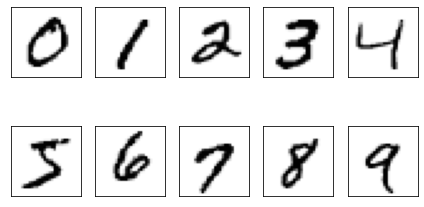

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

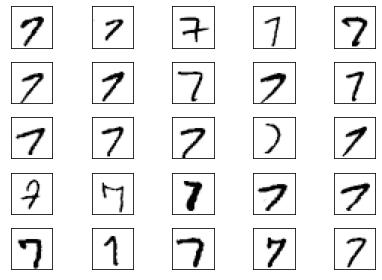

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [25]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [26]:
import numpy as np

In [27]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [28]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [29]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [30]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


In [31]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [32]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.2%


In [33]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [34]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.06 | Train Acc: 72.79% | Valid Acc: 72.92%
Epoch: 002/050 | Train MSE: 0.04 | Train Acc: 83.11% | Valid Acc: 82.48%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 86.96% | Valid Acc: 86.20%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.48% | Valid Acc: 88.10%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.45% | Valid Acc: 89.10%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.06% | Valid Acc: 89.64%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.53% | Valid Acc: 90.34%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 90.84% | Valid Acc: 90.66%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.33% | Valid Acc: 90.98%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 91.46% | Valid Acc: 91.24%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 91.67% | Valid Acc: 91.16%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 91.88% | Valid Acc: 91.48%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.23% | Valid Acc: 91.66%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.31

## Evaluating the neural network performance

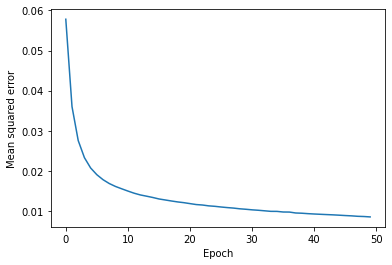

In [35]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

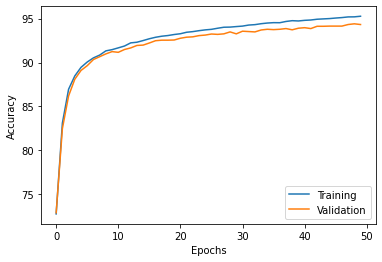

In [36]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [37]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.28%


Plot failure cases:

In [38]:
import sklearn
X_test_subset = X_test
y_test_subset = y_test

def softmax(a, axis=1):
    """
    Computes exp(a)/sumexp(a); relies on scipy logsumexp implementation.
    :param a: ndarray/tensor
    :param axis: axis to sum over; default (None) sums over everything
    """
    from scipy.special import logsumexp
    lse = logsumexp(a, axis=axis)  # this reduces along axis
    if axis is not None:
        lse = np.expand_dims(lse, axis)  # restore that axis for subtraction
    return np.exp(a - lse)


_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
print("one hidden leayers by us "+str(sklearn.metrics.roc_auc_score(y_test_subset,softmax(probas,1),multi_class='ovo', average='macro')))

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

one hidden leayers by us 0.9959891562489684


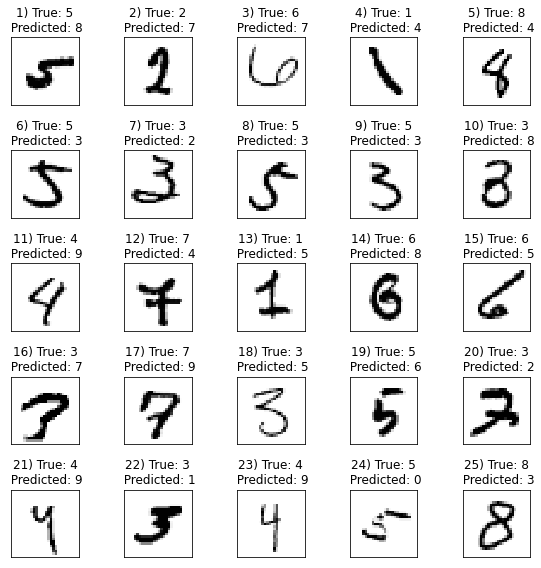

In [39]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# Training an artificial neural network

...

## Computing the loss function

In [ ]:
Image(filename='figures/11_10.png', width=300) 

<br>
<br>

## Developing your intuition for backpropagation

...

## Training neural networks via backpropagation

In [ ]:
Image(filename='./figures/11_11.png', width=400) 

In [ ]:
Image(filename='figures/11_12.png', width=500) 

In [ ]:
Image(filename='figures/11_13.png', width=500) 

<br>
<br>

# Convergence in neural networks

In [ ]:
Image(filename='figures/11_14.png', width=500) 

<br>
<br>

...

# Summary

...

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py
